In [32]:
#Importação de bibliotecas
import torch
import glob
import os
import pathlib
import cv2
import shutil
import random

import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt
import cv2                  as cv 
import matplotlib.pyplot    as plt
import torch.nn.functional  as F
import seaborn              as sns
import plotly.express       as px
import plotly.graph_objects as go

from random                  import sample
from plotly.subplots         import make_subplots
from google.colab            import drive
from google.colab.patches    import cv2_imshow
from skimage                 import io
from PIL                     import Image
from torch                   import nn, optim
from torchvision             import datasets, transforms
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("Versão:",torch.__version__)

Versão: 1.10.0+cu111


In [33]:
#Leituras de arquivo do drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
#Modelo de arquitetura da CNN
class classificador(nn.Module):
    def __init__ (self):
        super().__init__()
      
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=(1,1), padding=(0,0))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1,1), padding=(2,2))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=(1,1), padding=(2,2))

        self.activation = nn.ReLU() 
        self.bnorm = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=16384, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=4)

        self.dropout1 = nn.Dropout(p = 0.1)
        self.dropout2 = nn.Dropout(p = 0.2)
        
    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.dropout1(self.pool(self.activation(self.conv2(X))))
        X = self.dropout2(self.pool(self.activation(self.conv3(X))))
        X = self.flatten(X)
        
        X = self.activation(self.linear1(X))
        X = self.activation(self.linear2(X))
        X = self.output(X)
        
        return X

In [35]:
path_train = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/80_20_Brain_Tumor/BrainTumor_80/'
path_test = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/80_20_Brain_Tumor/BrainTumor_20/'

In [36]:
from torchvision.transforms.transforms import RandomHorizontalFlip
transform_train = transforms.Compose(
    [
     transforms.Resize([128,128]),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(45),
     transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
     transforms.Resize([128,128]),
     transforms.ToTensor()
    ]
)

In [37]:
train_dataset = datasets.ImageFolder(path_train, transform=transform_train)
test_dataset = datasets.ImageFolder(path_test, transform=transform_test)

In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [40]:
def get_class_distribution(dataset_obj):
  count_dict = {k:0 for k, v in dataset_obj.class_to_idx.items()}
  for i in dataset_obj:
    y_labels = i[1]
    y_labels = idx2class[y_labels]
    count_dict[y_labels] += 1
  return count_dict

idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}
df_treino = pd.DataFrame.from_dict([get_class_distribution(train_dataset)]).melt()

idx2class = {v: k for k, v in test_dataset.class_to_idx.items()}
df_teste = pd.DataFrame.from_dict([get_class_distribution(test_dataset)]).melt()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(
    labels=df_treino['variable'],
     values=df_treino['value'],
      pull=[0, 0, 0.1, 0]),
       1, 1)

fig.add_trace(go.Pie(
    labels=df_teste['variable'],
     values=df_teste['value'],
      pull=[0, 0, 0.1, 0]),
       1, 2)

fig.update_traces(hole=.4,
    hoverinfo='label+percent',
                  textinfo='value',
                  textfont_size=12.5,
                  marker=dict(
                      line=dict(
                          color='#000000',
                           width=1)
                      )
                  )

fig.update_layout(
    title_text = 'Proporção da base de dados de treino e teste',
    annotations=[dict(text='Treino', x=0.181, y=0.5, font_size=20, showarrow=False),
                 dict(text='Teste', x=0.80, y=0.5, font_size=20, showarrow=False)]
)

fig.show()

In [41]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [42]:
#Setamos a GPU necessária para realizar nossa classificação
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
print(device)

net.to(device)

cuda


classificador(
  (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (activation): ReLU()
  (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=16384, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=4, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [43]:
loss_values = []
accu_values = []
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    for i, data in enumerate(loader):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        #loss_values.append(running_loss / len(train_dataset))
        
        ps = F.softmax(outputs, dim=1)
        top_p, top_class = ps.topk(k=1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy= torch.mean(equals.type(torch.float))
        
        running_accuracy += accuracy
        
        #Imprimir os dados referentes a este loop
        print("Época {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}".format(epoch + 1, i+1, len(loader)\
                                                                                             , loss, accuracy), end= '\r')
    #Impressão referente à épocas
    print("Época {:3d} Finalizada: perda {:.5f} - precisão {:.5f}".format(epoch+1, running_loss/len(loader)\
                                                                         ,running_accuracy/len(loader)))
    loss_values.append(running_loss / len(loader))
    accu_values.append(running_accuracy/len(loader))

In [44]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values]

In [45]:
for epoch in range(100):
    print("Treinando...")
    training_loop(train_loader, epoch)
    net.eval()
    net.train()

Treinando...
Época   1 Finalizada: perda 1.17554 - precisão 0.46206
Treinando...
Época   2 Finalizada: perda 0.92788 - precisão 0.59826
Treinando...
Época   3 Finalizada: perda 0.82863 - precisão 0.66604
Treinando...
Época   4 Finalizada: perda 0.76956 - precisão 0.68532
Treinando...
Época   5 Finalizada: perda 0.75352 - precisão 0.68843
Treinando...
Época   6 Finalizada: perda 0.68313 - precisão 0.71082
Treinando...
Época   7 Finalizada: perda 0.67501 - precisão 0.71766
Treinando...
Época   8 Finalizada: perda 0.62681 - precisão 0.74689
Treinando...
Época   9 Finalizada: perda 0.61784 - precisão 0.74005
Treinando...
Época  10 Finalizada: perda 0.58187 - precisão 0.75311
Treinando...
Época  11 Finalizada: perda 0.54972 - precisão 0.76555
Treinando...
Época  12 Finalizada: perda 0.55727 - precisão 0.76555
Treinando...
Época  13 Finalizada: perda 0.50059 - precisão 0.79789
Treinando...
Época  14 Finalizada: perda 0.50792 - precisão 0.78669
Treinando...
Época  15 Finalizada: perda 0.47703

In [46]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values]
print(len(loss_train), len(accu_train))

100 100


In [47]:
accu_values.clear()
loss_values.clear()
for epoch in range(100):
    net.eval()
    print("Validando...")
    training_loop(test_loader, epoch)
    net.train()

Validando...
Época   1 Finalizada: perda 2.01776 - precisão 0.57576
Validando...
Época   2 Finalizada: perda 0.59826 - precisão 0.77576
Validando...
Época   3 Finalizada: perda 0.36664 - precisão 0.84242
Validando...
Época   4 Finalizada: perda 0.69404 - precisão 0.74091
Validando...
Época   5 Finalizada: perda 0.23424 - precisão 0.92121
Validando...
Época   6 Finalizada: perda 0.10341 - precisão 0.97576
Validando...
Época   7 Finalizada: perda 0.05151 - precisão 0.98788
Validando...
Época   8 Finalizada: perda 0.02708 - precisão 0.99545
Validando...
Época   9 Finalizada: perda 0.02057 - precisão 0.99394
Validando...
Época  10 Finalizada: perda 0.03408 - precisão 0.99091
Validando...
Época  11 Finalizada: perda 0.01500 - precisão 0.99545
Validando...
Época  12 Finalizada: perda 0.01517 - precisão 0.99545
Validando...
Época  13 Finalizada: perda 0.01661 - precisão 0.99394
Validando...
Época  14 Finalizada: perda 0.01511 - precisão 0.99394
Validando...
Época  15 Finalizada: perda 0.01521

In [48]:
loss_test = [item for item in loss_values]
accu_test = [item for item in accu_values]

In [49]:
print(len(loss_test), len(accu_test))

100 100


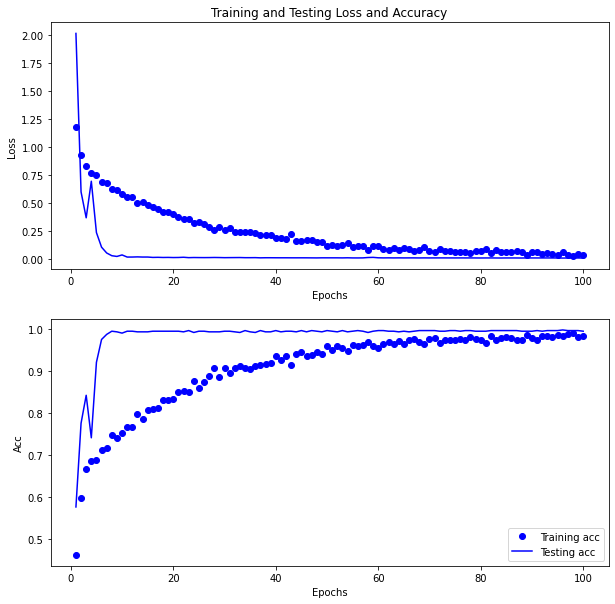

In [50]:
epochs_x = range(1, len(loss_test) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_train, 'bo', label='Training loss')
plt.plot(epochs_x, loss_test, 'b', label='Testing loss')
plt.title('Training and Testing Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(epochs_x, accu_train, 'bo', label='Training acc')
plt.plot(epochs_x, accu_test, 'b', label='Testing acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [51]:
numero_de_classes = 4

matriz = torch.zeros(numero_de_classes, numero_de_classes)
with torch.no_grad():
  for i, (inputs, classes) in enumerate(test_loader):
    inputs = inputs.to(device)
    outputs = net(inputs)
    _, previsao = torch.max(outputs, 1)
    for k, l in zip(classes.view(-1), previsao.view(-1)):
      matriz[k.long(), l.long()] += 1

In [52]:
print(matriz)

tensor([[182.,   1.,   2.,   0.],
        [ 17., 168.,   1.,   1.],
        [  2.,   0.,  98.,   0.],
        [  6.,   0.,   0., 174.]])


In [53]:
print(matriz.diag()/matriz.sum(1))

tensor([0.9838, 0.8984, 0.9800, 0.9667])
